In [ ]:
from os.path import join as pjoin
from os import listdir, mkdir
from os.path import basename, isfile, isdir

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from lib.figure_5 import calculate_correlation_statistics

calculate_correlation_statistics()

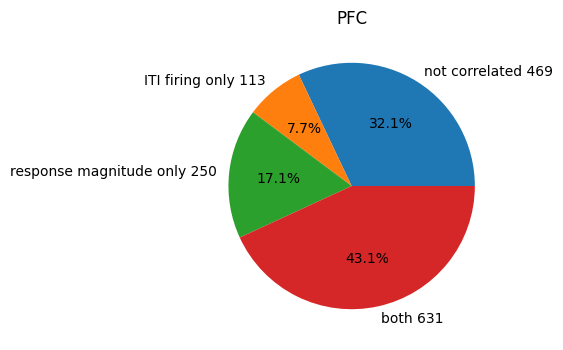

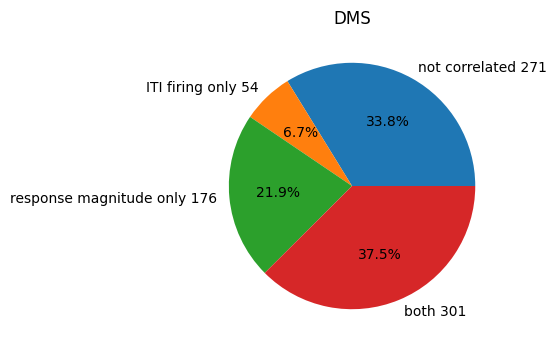

In [9]:
from lib.figure_5 import get_figure_5_panel_ef_left

get_figure_5_panel_ef_left(prpd=False)

pfc response:  Ttest_indResult(statistic=2.028270109951697, pvalue=0.04729923444104841)
pfc background:  Ttest_indResult(statistic=2.301098418927752, pvalue=0.02513113113788076)
dms response:  Ttest_indResult(statistic=0.7422110602915795, pvalue=0.46106133517460945)
dms background:  Ttest_indResult(statistic=1.3997767989881607, pvalue=0.1670957833689282)


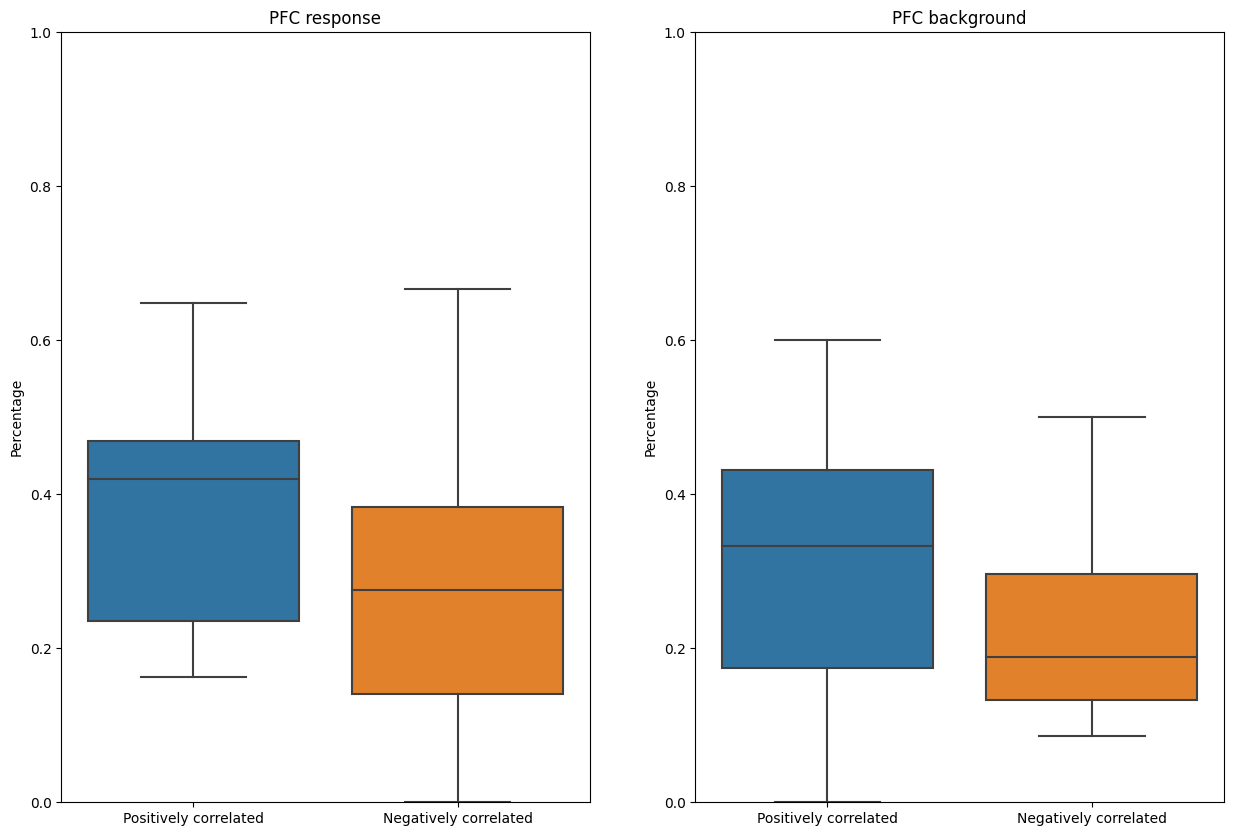

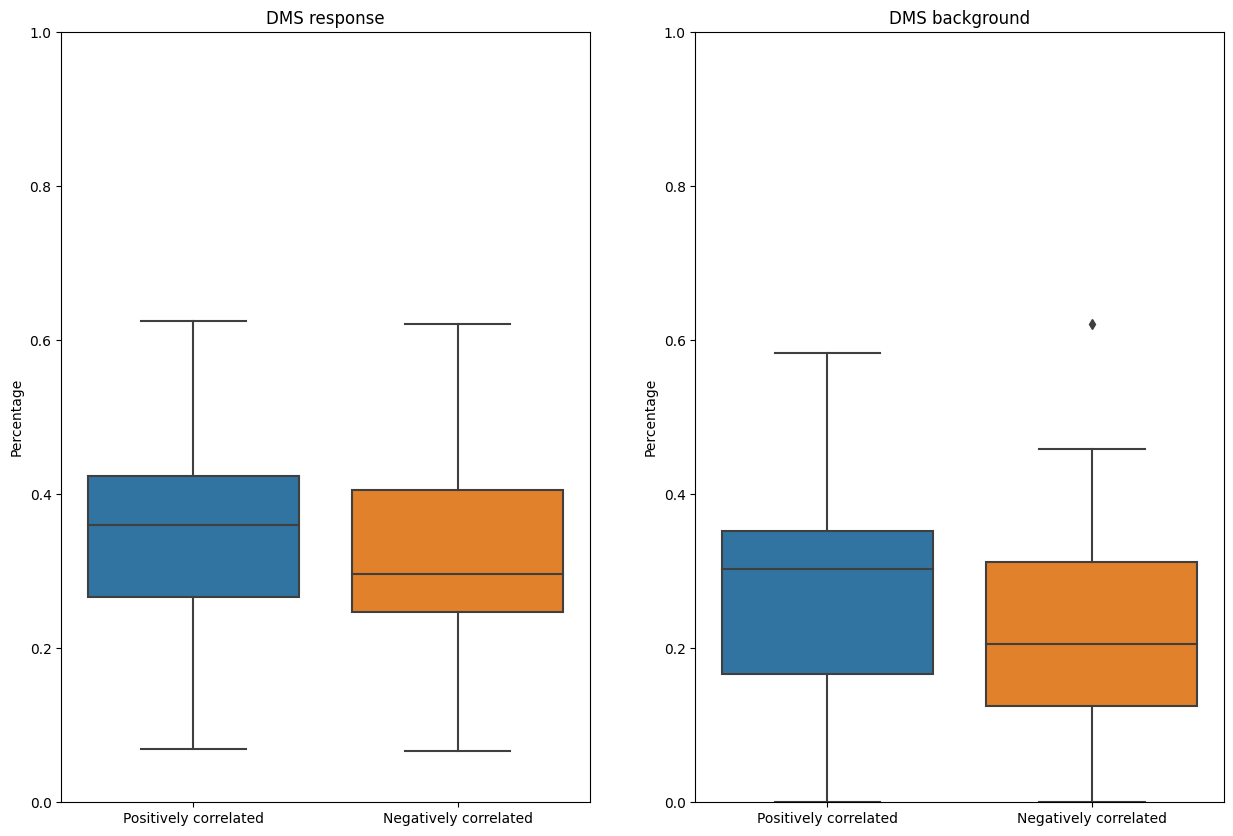

In [2]:
from lib.figure_5 import get_figure_5_panel_ef_right

get_figure_5_panel_ef_right()

pfc response:  Ttest_indResult(statistic=2.555251530476325, pvalue=0.013982835609403782)
pfc background:  Ttest_indResult(statistic=1.6909324601113846, pvalue=0.09761554991883135)
dms response:  Ttest_indResult(statistic=0.12198719715706817, pvalue=0.9034405249044942)
dms background:  Ttest_indResult(statistic=0.8565854897625769, pvalue=0.39611447655586063)


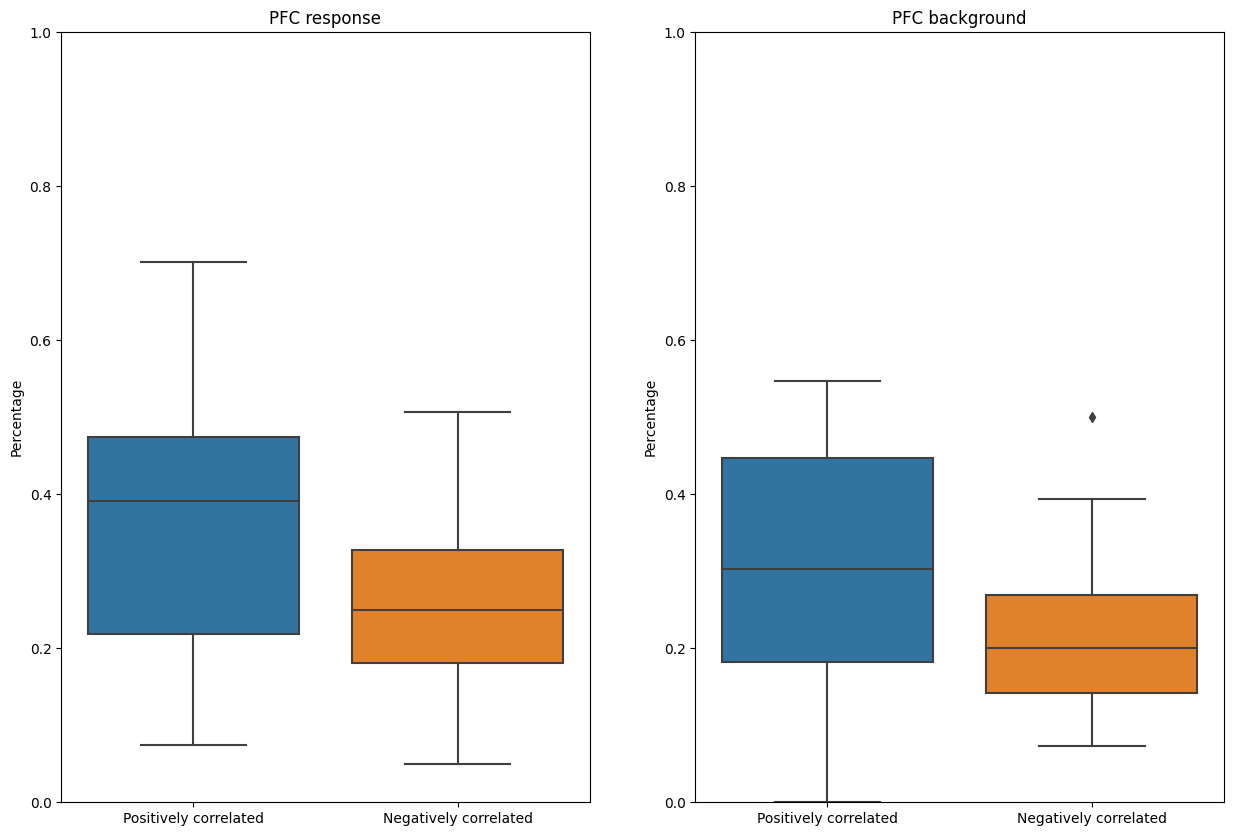

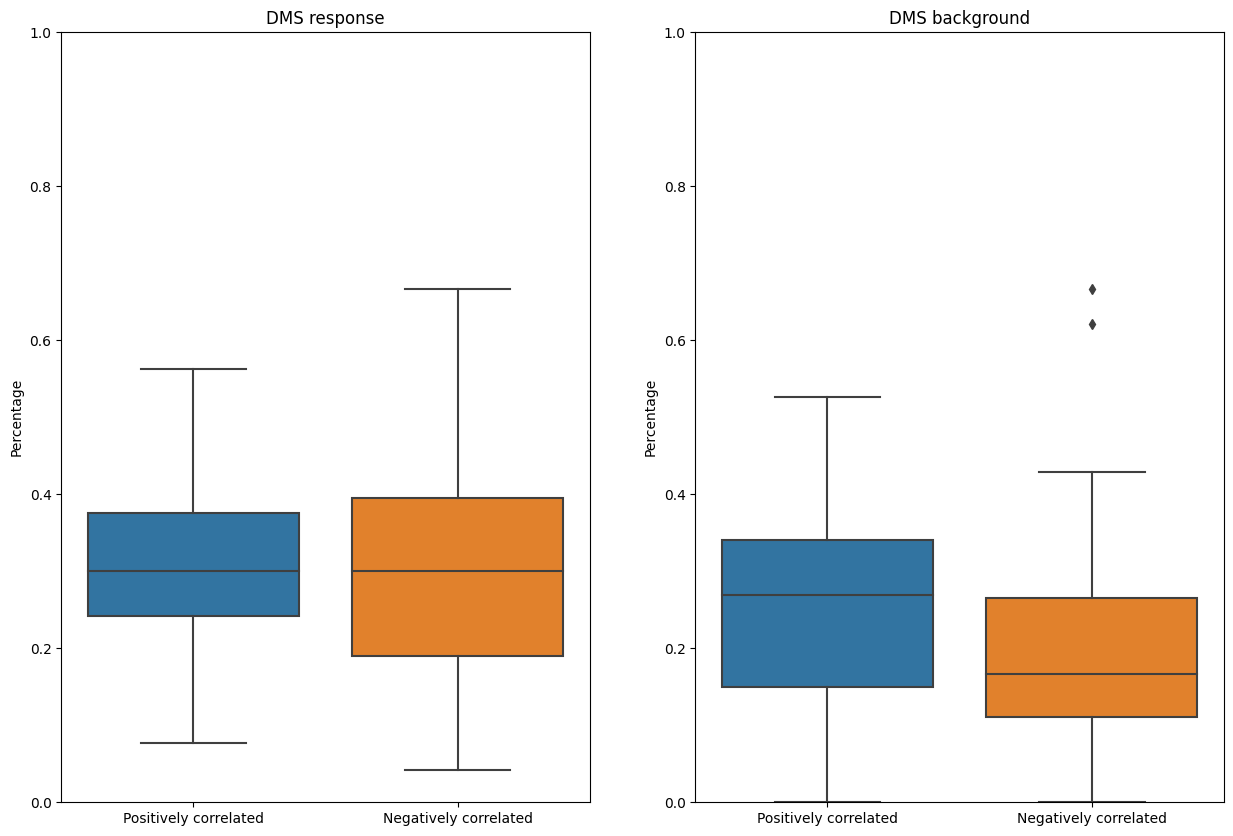

In [11]:
from lib.figure_5 import get_figure_5_panel_ef_right

get_figure_5_panel_ef_right(prpd=False)